# Compare Gromov-Wasserstein and traditional OT

## Imports and magics

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as ipyw
from ot import emd
from ot.utils import dist 
from ot.gromov import gromov_wasserstein
from scipy.io import loadmat

from otimage import imagerep, readers
from otimage.utils import plot_maxproj

## Transport plans

In [3]:
def normalized_dist_mtx(pts_1, pts_2, metric):
    """Return distance matrix normalized by median."""
    
    mtx_nn = dist(pts_1, pts_2, metric=metric)
    return mtx_nn / np.median(mtx_nn)

def compute_ot(pts_1, pts_2, wts_1, wts_2):
    """Normalize weights and compute OT matrix."""
    
    # Normalize weights
    p_1 = wts_1 / np.sum(wts_1)
    p_2 = wts_2 / np.sum(wts_2)

    # Normalized distance matrix 
    c_mtx = normalized_dist_mtx(pts_1, pts_2, 'sqeuclidean')
    
    # Compute transport plan
    return emd(p_1, p_2, c_mtx, log=True)

def compute_gw(pts_1, pts_2, wts_1, wts_2):
    """Normalize weights and compute OT matrix."""
    
    # Normalize weights
    p_1 = wts_1 / np.sum(wts_1)
    p_2 = wts_2 / np.sum(wts_2)

    # Normalized distance matrices
    c_1 = normalized_dist_mtx(pts_1, pts_1, metric='sqeuclidean')
    c_2 = normalized_dist_mtx(pts_2, pts_2, metric='sqeuclidean')
    
    # Compute transport plan
    return gromov_wasserstein(c_1, c_2, p_1, p_2, 'square_loss', log=True)

## Load data

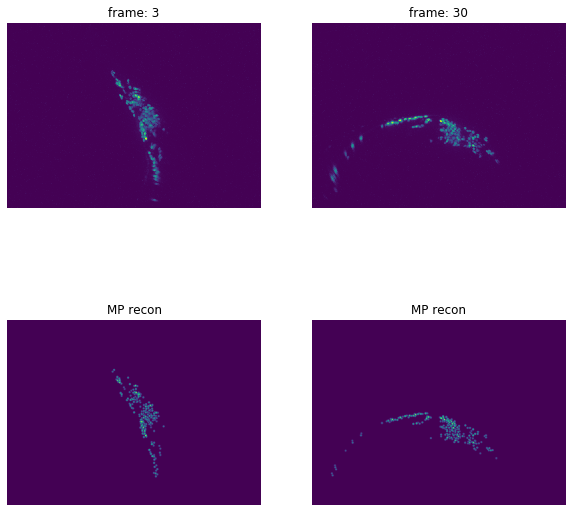

In [4]:
# Frame index
t1 = 3
t2 = 30

# Load two successive frames from dataset
img_path = '/home/mn2822/Desktop/WormOT/data/zimmer/raw/mCherry_v00065-00115.hdf5'
with readers.ZimmerReader(img_path) as reader:
    img_1 = reader.get_frame(t1)
    img_2 = reader.get_frame(t2)
    img_shape = img_1.shape

# Load MP components
mp_path = '/home/mn2822/Desktop/WormOT/data/zimmer/mp_components/mp_0000_0050.mat'
mp_data = loadmat(mp_path)
cov = mp_data['cov']
pts_1 = mp_data['means'][t1, :, :]
pts_2 = mp_data['means'][t2, :, :]
wts_1 = mp_data['weights'][t1, :, 0]
wts_2 = mp_data['weights'][t2, :, 0]

# Reconstruct images from MPs
rec_1 = imagerep.reconstruct_image(pts_1, [cov], wts_1, img_shape)
rec_2 = imagerep.reconstruct_image(pts_2, [cov], wts_2, img_shape)
  
plt.figure(figsize=(10, 10))

plt.subplot(221)
plot_maxproj(img_1)
plt.title(f'frame: {t1}')
plt.axis('off')

plt.subplot(222)
plot_maxproj(img_2)
plt.title(f'frame: {t2}')
plt.axis('off');

plt.subplot(223)
plot_maxproj(rec_1)
plt.title('MP recon')
plt.axis('off')

plt.subplot(224)
plot_maxproj(rec_2)
plt.title('MP recon')
plt.axis('off');

## Compute transport plans

In [5]:
t_ot, ot_log = compute_ot(pts_1, pts_2, wts_1, wts_2)
t_gw, gw_log = compute_gw(pts_1, pts_2, wts_1, wts_2)

## Examine transport plans

### Widget for viewing rows of transport plans

In [6]:
def plot_rows(idx):
    
    fig, (ax_1, ax_2) = plt.subplots(2, 1, sharex=True, sharey=True)

    ax_1.plot(t_ot[idx, :])
    ax_1.set_title('OT')
    ax_1.get_xaxis().set_visible(False)

    ax_2.plot(t_gw[idx, :])
    ax_2.set_title('GW');

ipyw.interact(
    plot_rows, 
    idx=ipyw.IntSlider(
        min=0, max=pts_1.shape[0], step=1, 
        continuous_update=False, description='MP:'
    )
);

interactive(children=(IntSlider(value=0, continuous_update=False, description='MP:', max=200), Output()), _dom…

In [7]:
q_ot = t_ot / np.sum(t_ot, 1)[:, np.newaxis]
pf_means_ot = q_ot @ pts_2
pf_modes_ot = pts_2[np.argmax(q_ot, 1)]

q_gw = t_gw / np.sum(t_gw, 1)[:, np.newaxis]
pf_means_gw = q_gw @ pts_2
pf_modes_gw = pts_2[np.argmax(q_gw, 1)]
 
        
def plot_pushforward_compare(idx):
        
    pt_1 = pts_1[idx, :]
    mean_pf_ot = pf_means_ot[idx, :]
    mode_pf_ot = pf_modes_ot[idx, :]
    mean_pf_gw = pf_means_gw[idx, :]
    mode_pf_gw = pf_modes_gw[idx, :]

    fig, (ax_1, ax_2, ax_3) = plt.subplots(1, 3, figsize=(15, 15))

    ax_1.imshow(np.max(rec_1, 2).T, origin='lower')
    ax_1.plot(pt_1[0], pt_1[1], marker='*', color='red', markersize=7)
    ax_1.get_xaxis().set_visible(False)
    ax_1.get_yaxis().set_visible(False)
    ax_1.set_title(f'MP: {idx}')

    ax_2.imshow(np.max(rec_2, 2).T, origin='lower')
    ax_2.plot(mean_pf_ot[0], mean_pf_ot[1], marker='*', color='red', markersize=7)
    ax_2.plot(mode_pf_ot[0], mode_pf_ot[1], marker='+', color='red', markersize=7)
    ax_2.get_xaxis().set_visible(False)
    ax_2.get_yaxis().set_visible(False)
    ax_2.set_title('pushforward (OT)')
    
    ax_3.imshow(np.max(rec_2, 2).T, origin='lower')
    ax_3.plot(mean_pf_gw[0], mean_pf_gw[1], marker='*', color='red', markersize=7)
    ax_3.plot(mode_pf_gw[0], mode_pf_gw[1], marker='+', color='red', markersize=7)
    ax_3.get_xaxis().set_visible(False)
    ax_3.get_yaxis().set_visible(False)
    ax_3.set_title('pushforward (GW)')
    
ipyw.interact(
    plot_pushforward_compare,
    idx=ipyw.IntSlider(
        min=0, max=pts_1.shape[0], step=1, 
        continuous_update=False, description='MP:'
    )
);

interactive(children=(IntSlider(value=0, continuous_update=False, description='MP:', max=200), Output()), _dom…